In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../dataset/split-images-lr'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return train_loss, train_acc, val_loss, val_acc, model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [4]:
model_ft = models.resnet18(pretrained=True)
# print(model_ft)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
train_loss, train_acc, val_loss, val_acc, model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0611 Acc: 0.6977
val Loss: 0.7822 Acc: 0.7745

Epoch 1/24
----------
train Loss: 1.0556 Acc: 0.7002
val Loss: 0.7691 Acc: 0.7729

Epoch 2/24
----------
train Loss: 1.0535 Acc: 0.7001
val Loss: 0.7739 Acc: 0.7755

Epoch 3/24
----------
train Loss: 1.0556 Acc: 0.6973
val Loss: 0.8036 Acc: 0.7735

Epoch 4/24
----------
train Loss: 1.0592 Acc: 0.6989
val Loss: 0.7816 Acc: 0.7775

Epoch 5/24
----------
train Loss: 1.0561 Acc: 0.6972
val Loss: 0.7739 Acc: 0.7765

Epoch 6/24
----------
train Loss: 1.0615 Acc: 0.6980
val Loss: 0.7954 Acc: 0.7766

Epoch 7/24
----------
train Loss: 1.0603 Acc: 0.6967
val Loss: 0.7708 Acc: 0.7778

Epoch 8/24
----------
train Loss: 1.0515 Acc: 0.7004
val Loss: 0.7809 Acc: 0.7738

Epoch 9/24
----------
train Loss: 1.0476 Acc: 0.6999
val Loss: 0.7862 Acc: 0.7782

Epoch 10/24
----------
train Loss: 1.0504 Acc: 0.6989
val Loss: 0.7800 Acc: 0.7763

Epoch 11/24
----------
train Loss: 1.0492 Acc: 0.6994
val Loss: 0.7821 Acc: 0.7766

Ep

In [7]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i].item()
    val_acc[i] = val_acc[i].item()

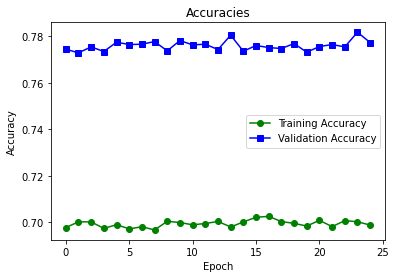

In [8]:
fig, ax = plt.subplots()
x = range(0,25,1)
train_list = list(train_acc)
val_list = list(val_acc)
ax.plot(x, train_list, 'go-', label='Training Accuracy')
ax.plot(x, val_list, 'bs-', label='Validation Accuracy')
ax.set_title('Accuracies')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

In [9]:
model_new = model_ft
model_new.fc = nn.Identity()
torch.save(model_new.state_dict(), 'model_resnet18.pth')

In [10]:
images_all = None
labels_all = None
for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.numpy()
    if labels_all is None:
        labels_all = labels
    else:
        labels_all = np.concatenate((labels_all, labels))
    outputs = model_new(images).detach().cpu().numpy()
    if images_all is None:
        images_all = outputs
    else:
        images_all = np.concatenate((images_all, outputs)) 

In [14]:
model_ft_34 = models.resnet34(pretrained=True)
# print(model_ft)
num_ftrs_34 = model_ft_34.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_34.fc = nn.Linear(num_ftrs_34, len(class_names))

model_ft_34 = model_ft_34.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_34 = optim.SGD(model_ft_34.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_34 = lr_scheduler.StepLR(optimizer_ft_34, step_size=7, gamma=0.1)

train_loss_34, train_acc_34, val_loss_34, val_acc_34, model_ft_34 = train_model(model_ft_34, criterion, optimizer_ft_34, exp_lr_scheduler_34,
                       num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/abhishek/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100.0%


Epoch 0/24
----------
train Loss: 2.4479 Acc: 0.3890
val Loss: 1.5448 Acc: 0.6171

Epoch 1/24
----------
train Loss: 1.9205 Acc: 0.4880
val Loss: 1.2294 Acc: 0.6581

Epoch 2/24
----------
train Loss: 1.7469 Acc: 0.5286
val Loss: 1.2882 Acc: 0.6760

Epoch 3/24
----------
train Loss: 1.6095 Acc: 0.5585
val Loss: 1.2027 Acc: 0.6840

Epoch 4/24
----------
train Loss: 1.5063 Acc: 0.5812
val Loss: 1.0649 Acc: 0.7002

Epoch 5/24
----------
train Loss: 1.4210 Acc: 0.6055
val Loss: 1.0747 Acc: 0.7109

Epoch 6/24
----------
train Loss: 1.3514 Acc: 0.6180
val Loss: 1.0987 Acc: 0.6647

Epoch 7/24
----------
train Loss: 1.0933 Acc: 0.6857
val Loss: 0.8032 Acc: 0.7729

Epoch 8/24
----------
train Loss: 1.0226 Acc: 0.7040
val Loss: 0.7475 Acc: 0.7851

Epoch 9/24
----------
train Loss: 0.9965 Acc: 0.7120
val Loss: 0.7435 Acc: 0.7855

Epoch 10/24
----------
train Loss: 0.9720 Acc: 0.7164
val Loss: 0.7403 Acc: 0.7783

Epoch 11/24
----------
train Loss: 0.9588 Acc: 0.7215
val Loss: 0.7111 Acc: 0.7898

Ep

In [15]:
for i in range(len(train_acc_34)):
    train_acc_34[i] = train_acc_34[i].item()
    val_acc_34[i] = val_acc_34[i].item()

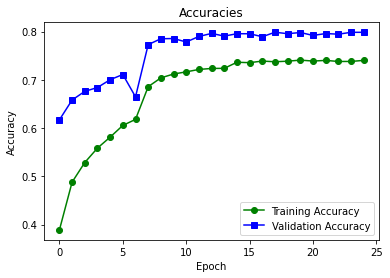

In [16]:
fig, ax = plt.subplots()
x = range(0,25,1)
ax.plot(x, train_acc_34, 'go-', label='Training Accuracy')
ax.plot(x, val_acc_34, 'bs-', label='Validation Accuracy')
ax.set_title('Accuracies')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

In [17]:
model_new_34 = model_ft_34
model_new_34.fc = nn.Identity()
torch.save(model_new_34.state_dict(), 'model_resnet34.pth')

In [18]:
images_all = None
labels_all = None
for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.numpy()
    if labels_all is None:
        labels_all = labels
    else:
        labels_all = np.concatenate((labels_all, labels))
    outputs = model_new_34(images).detach().cpu().numpy()
    if images_all is None:
        images_all = outputs
    else:
        images_all = np.concatenate((images_all, outputs)) 

In [22]:
model_ft_50 = models.resnet50(pretrained=True)
# print(model_ft)
num_ftrs_50 = model_ft_50.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_50.fc = nn.Linear(num_ftrs_50, len(class_names))

model_ft_50 = model_ft_50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_50 = optim.SGD(model_ft_50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_50 = lr_scheduler.StepLR(optimizer_ft_50, step_size=7, gamma=0.1)

train_loss_50, train_acc_50, val_loss_50, val_acc_50, model_ft_50 = train_model(model_ft_50, criterion, optimizer_ft_50, exp_lr_scheduler_50,
                       num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/abhishek/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


Epoch 0/24
----------
train Loss: 2.4214 Acc: 0.3949
val Loss: 1.3934 Acc: 0.6241

Epoch 1/24
----------
train Loss: 1.8504 Acc: 0.5032
val Loss: 1.3794 Acc: 0.6674

Epoch 2/24
----------
train Loss: 1.6442 Acc: 0.5488
val Loss: 1.1760 Acc: 0.6996

Epoch 3/24
----------
train Loss: 1.5222 Acc: 0.5766
val Loss: 1.0089 Acc: 0.7188

Epoch 4/24
----------
train Loss: 1.4220 Acc: 0.6006
val Loss: 0.9858 Acc: 0.7181

Epoch 5/24
----------
train Loss: 1.3519 Acc: 0.6182
val Loss: 0.9756 Acc: 0.7384

Epoch 6/24
----------
train Loss: 1.2875 Acc: 0.6327
val Loss: 0.9433 Acc: 0.7307

Epoch 7/24
----------
train Loss: 1.0491 Acc: 0.6965
val Loss: 0.7007 Acc: 0.7912

Epoch 8/24
----------
train Loss: 0.9505 Acc: 0.7228
val Loss: 0.6965 Acc: 0.7932

Epoch 9/24
----------
train Loss: 0.9429 Acc: 0.7224
val Loss: 0.6722 Acc: 0.7971

Epoch 10/24
----------
train Loss: 0.9012 Acc: 0.7317
val Loss: 0.6871 Acc: 0.7938

Epoch 11/24
----------
train Loss: 0.8997 Acc: 0.7350
val Loss: 0.6950 Acc: 0.7987

Ep

In [23]:
for i in range(len(train_acc_50)):
    train_acc_50[i] = train_acc_50[i].item()
    val_acc_50[i] = val_acc_50[i].item()

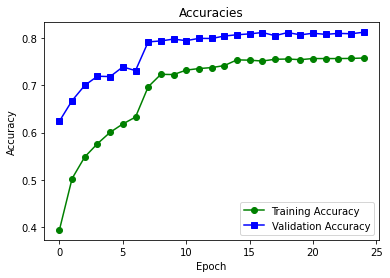

In [24]:
fig, ax = plt.subplots()
x = range(0,25,1)
ax.plot(x, train_acc_50, 'go-', label='Training Accuracy')
ax.plot(x, val_acc_50, 'bs-', label='Validation Accuracy')
ax.set_title('Accuracies')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

In [25]:
model_new_50 = model_ft_50
model_new_50.fc = nn.Identity()
torch.save(model_new_50.state_dict(), 'model_resnet50.pth')

In [26]:
images_all = None
labels_all = None
for images, labels in dataloaders['test']:
    images = images.to(device)
    labels = labels.numpy()
    if labels_all is None:
        labels_all = labels
    else:
        labels_all = np.concatenate((labels_all, labels))
    outputs = model_new_50(images).detach().cpu().numpy()
    if images_all is None:
        images_all = outputs
    else:
        images_all = np.concatenate((images_all, outputs)) 